In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain

from xsigmamodules.common import helper
from xsigmamodules.test import Testing
from xsigmamodules.market import market_data
from xsigmamodules.simulation import simulation
from xsigmamodules.util.misc import xsigmaGetDataRoot, xsigmaGetTempDir

from xsigmamodules.Analytics import (
    calibrationIrTargetsConfiguration,
    calibrationHjmSettings,
    calibrationIrHjm,
    correlationManager,
    correlationManagerId,
    dynamicInstructionId,
    dynamicInstructionIrId,
    dynamicInstructionIrMarkovianHjm,
    dynamicInstructionFxId,
    dynamicInstructionFxLognormal,
    simulatedMarketDataIrId,
    simulatedMarketDataFxId,
    simulationManager,
    parameter_markovian_hjm_enum,
    parameterMarkovianHjmId,
    parameterMarkovianHjm,
    parameterLognormal,
    parameterLognormalId,
    measureId,
    measure,
    randomConfig,
    randomConfigId,
    lognormalFxWithMhjmIr,
)
from xsigmamodules.Market import (
    discountCurveInterpolated,
    irVolatilitySabr,
    discountCurve,
    discountCurveId,
    fxForwardMarket,
    fxForwardId,
    anyId,
    anyContainer,
    anyObject,
)
from xsigmamodules.Util import dayCountConvention, blackScholes
from xsigmamodules.Random import random_enum
from xsigmamodules.util.numpy_support import xsigmaToNumpy, numpyToXsigma
from xsigmamodules.Vectorization import vector, matrix, tensor, tensor

In [2]:
XSIGMA_DATA_ROOT = xsigmaGetDataRoot()
XSIGMA_TEST_ROOT = xsigmaGetTempDir()
# print(XSIGMA_DATA_ROOT)

In [3]:
dom_ir_id = discountCurveId("USD", "LIBOR.3M.USD")
diffusion_dom_id = simulatedMarketDataIrId(dom_ir_id)

for_ir_id = discountCurveId("EUR", "LIBOR.3M.USD")
diffusion_for_id = simulatedMarketDataIrId(for_ir_id)

fx_forward_id = fxForwardId(dom_ir_id, for_ir_id)
diffusion_fx_id = simulatedMarketDataFxId(fx_forward_id)

simulated_ids = [diffusion_dom_id, diffusion_for_id, diffusion_fx_id]

In [4]:
anyids = [anyId(dynamicInstructionIrId(diffusion_dom_id))]
anyobject = [anyObject(dynamicInstructionIrMarkovianHjm())]

anyids.append(anyId(dynamicInstructionIrId(diffusion_for_id)))
anyobject.append(anyObject(dynamicInstructionIrMarkovianHjm()))

anyids.append(anyId(dynamicInstructionFxId(diffusion_fx_id)))
anyobject.append(anyObject(dynamicInstructionFxLognormal()))

In [5]:
params_dom = parameterMarkovianHjm.read_from_json(
    XSIGMA_DATA_ROOT + "/Data/parameterMarkovianHjmLIBOR.3M.USD_USD.json"
)
anyids.append(anyId(parameterMarkovianHjmId(diffusion_dom_id)))
anyobject.append(anyObject(params_dom))

params_for = parameterMarkovianHjm.read_from_json(
    XSIGMA_DATA_ROOT + "/Data/parameterMarkovianHjmLIBOR.3M.USD_EUR.json"
)
anyids.append(anyId(parameterMarkovianHjmId(diffusion_for_id)))
anyobject.append(anyObject(params_for))

In [ ]:
discount_curve = discountCurveInterpolated.read_from_json(
    XSIGMA_DATA_ROOT + "/Data/discountCurve.json"
)
anyids.append(anyId(dom_ir_id))
anyobject.append(anyObject(discount_curve))

anyids.append(anyId(for_ir_id))
anyobject.append(anyObject(discount_curve))

fx_forward = fxForwardMarket(
    discount_curve.valuation_date(), 1, discount_curve, discount_curve
)
anyids.append(anyId(fx_forward_id))
anyobject.append(anyObject(fx_forward))

In [7]:
correlation_mgr = correlationManager.read_from_json(
    XSIGMA_DATA_ROOT + "/Data/correlationManager.json"
)
anyids.append(anyId(correlationManagerId()))
anyobject.append(anyObject(correlation_mgr))

In [8]:
correlation = correlation_mgr.pair_correlation_matrix(simulated_ids, simulated_ids)
valuation_date = correlation_mgr.valuation_date()
calibrator = lognormalFxWithMhjmIr(valuation_date, correlation, params_dom, params_for)

convention = dayCountConvention()

calibration_dates = helper.simulation_dates(valuation_date, "3M", 120)
expiry_fraction = helper.convert_dates_to_fraction(
    valuation_date, calibration_dates, convention
)

volatility = 0.3
market_variance = []
for i in range(0, len(calibration_dates)):
    market_variance.append(volatility * volatility * expiry_fraction[i])

In [9]:
params_fx = calibrator.calibrate(calibration_dates, market_variance, convention)
anyids.append(anyId(parameterLognormalId(diffusion_fx_id)))
anyobject.append(anyObject(params_fx))

In [10]:
anyids.append(anyId(measureId()))
anyobject.append(anyObject(measure(dom_ir_id)))

num_of_paths = 262144 * 2
config = randomConfigBuilder().with_main_generator_type(random_enum.SOBOL_BROWNIAN_BRIDGE).with_seed(542897).with_number_of_paths_per_batch(num_of_paths).build()
anyids.append(anyId(randomConfigId()))
anyobject.append(anyObject(config))

In [11]:
market = anyContainer(anyids, anyobject)
simulation_mgr = simulationManager(simulated_ids, market, calibration_dates)

In [12]:
maturity = max(calibration_dates)

diffusion_curve_domestic = simulation_mgr.discount_curve(diffusion_dom_id)
diffusion_curve_foreign = simulation_mgr.discount_curve(diffusion_for_id)
diffusion_fx = simulation_mgr.fx_forward(diffusion_fx_id)

dis_for_curve = discount_curve
dis_dom_curve = discount_curve

mm_dom = np.zeros(num_of_paths)
mm_for = np.zeros(num_of_paths)
spot_fx_fwd = np.zeros(num_of_paths)
log_discount_factor = np.zeros(num_of_paths)

mm_dom_ = numpyToXsigma(mm_dom)
mm_for_ = numpyToXsigma(mm_for)
spot_fx_fwd_ = numpyToXsigma(spot_fx_fwd)
log_discount_factor_ = numpyToXsigma(log_discount_factor)

results_mm_market = []
results_df_market = []
results_mm = []
results_df = []
model_vol = []
market_vol = []
model_stradle_vol = []
fwds = []
strikes = []

df_for_maturity = dis_for_curve.df(valuation_date, maturity)

simulation_mgr.states_initialize(0)
for t in range(1, len(calibration_dates)):
    conditional_date = calibration_dates[t]
    simulation_mgr.propagate(t)

    diffusion_curve_domestic.discounting(mm_dom_, conditional_date)

    diffusion_curve_foreign.discounting(mm_for_, conditional_date)
    diffusion_curve_foreign.log_df(log_discount_factor_, conditional_date, maturity)

    diffusion_fx.forward(spot_fx_fwd_, conditional_date)

    # martingal rules:
    df_for_market = dis_for_curve.df(valuation_date, conditional_date)
    df_dom_market = dis_dom_curve.df(valuation_date, conditional_date)
    results_mm_market.append(0.0)
    results_mm.append(np.average(mm_dom * spot_fx_fwd / mm_for) - 1.0)
    results_df_market.append(0.0)
    results_df.append(
        np.average(mm_dom * np.exp(log_discount_factor) * spot_fx_fwd) / df_for_maturity
        - 1
    )

    fwd = fx_forward.forward(conditional_date)
    strike = np.average(mm_dom * spot_fx_fwd) / np.average(mm_dom) - 1.0
    strikes.append(strike)
    fwds.append(fwd)
    # option pricing:
    model_stradle_vol.append(np.average(mm_dom * (spot_fx_fwd - fwd)))
    fx_call_price = np.average(mm_dom * np.maximum(spot_fx_fwd - fwd, 0.0))
    fx_put_price = np.average(mm_dom * np.maximum(fwd - spot_fx_fwd, 0.0))
    expiry_double = convention.fraction(valuation_date, conditional_date)
    model_vol.append(
        0.5
        * (
            blackScholes.implied_volatility(
                fwd, fwd, expiry_double, fx_call_price, df_dom_market, 1.0
            )
            + blackScholes.implied_volatility(
                fwd, fwd, expiry_double, fx_put_price, df_dom_market, -1.0
            )
        )
    )
    market_vol.append(np.sqrt(market_variance[t] / expiry_double))

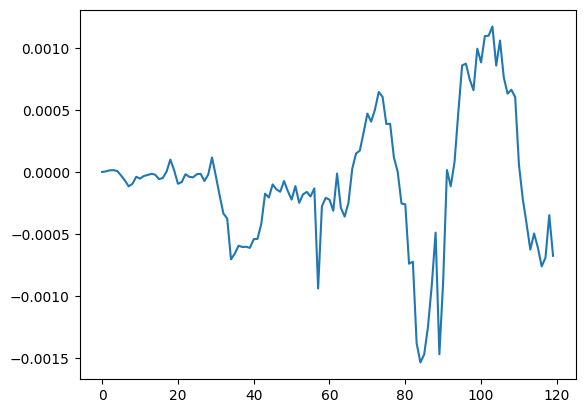

In [13]:
plt.plot(strikes)
# plt.plot(fwds)
# print(strikes)
plt.show()

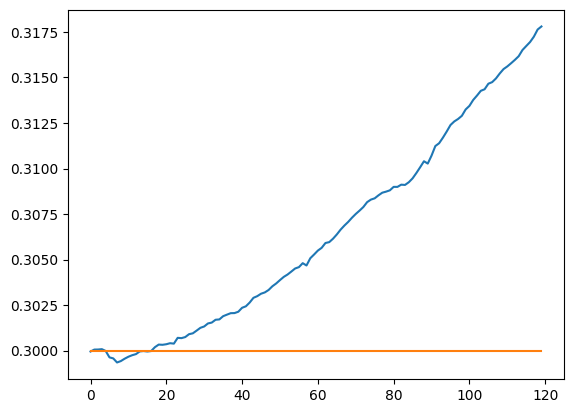

In [14]:
plt.plot(model_vol)
plt.plot(market_vol)
plt.show()

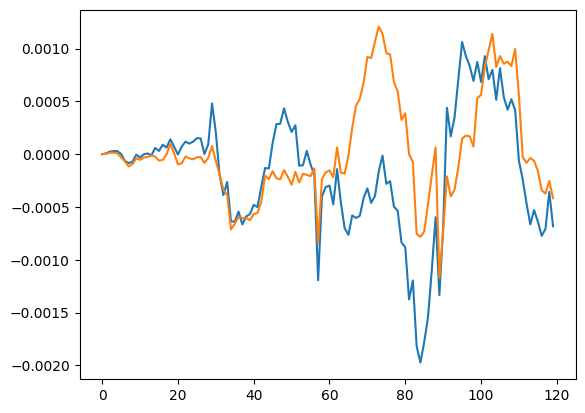

In [15]:
plt.plot(results_df)
plt.plot(results_mm)
plt.show()